## Dodatne naloge
Dodatne naloge naj služijo za poglobitev spretnosti programiranja, boljšemu razumevanju snovi in vsebine vaje in spoznavanju dodatnih načinov za obdelavo in analizo medicinskih slik. Opravljanje dodatnih nalog je neobvezno, vendar pa priporočljivo, saj je na nek način to priprava na zagovor laboratorijskih vaj.

1. Z 2D togo preslikavo $(t_x, t_y, \alpha) = (40 mm,\, -20 mm,\, 30^{\circ})$  preslikajte 2D mrežo kontrolnih točk, ki ste jih ustvarili pri Nalogi 2 v navodilih s funkcijo `getCubicBSpline2DGrid()`. 
  - Izrišite polje deformacij v obliki vektorskega polja z ukazom `quiver` v knjižici `matplotlib.pyplot`.
  - Sliko šahovnice iz Naloge 2 v navodilih preslikajte z dobljenim poljem deformacij in jo prikažite.

In [12]:
# YOUR CODE HERE
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel

2. Analitično izračunajte odvode $d/du$ baznih funkcij kubičnih B-zlepkov $B_l(u), l=0,1,2,3$.

In [5]:
# YOUR ANSWER HERE
def B0(u):
    # YOUR CODE HERE
    return (1 - u) ** 3.0 / 6.0


def B1(u):
    # YOUR CODE HERE
    return (3 * u ** 3 - 6 * u ** 2 + 4) / 6


def B2(u):
    # YOUR CODE HERE
    return (-3 * u ** 3 + 3 * u ** 2 + 3 * u + 1) / 6


def B3(u):
    # YOUR CODE HERE
    return u ** 3 / 6

def dB0(u):
    return -0.5 * (1 - u) ** 2


def dB1(u):
    return 1.5 * u ** 2 - 2 * u


def dB2(u):
    return -1.5 * u ** 2 + u + 0.5


def dB3(u):
    return 0.5 * u ** 2

B = [B0, B1, B2, B3]

dB = [dB0, dB1, dB2, dB3] 

3. Napišite funkcijo, ki za dano 2D mrežo kontrolnih točk kubičnih B-zlepkov izračuna polje Jacobijeve determinante:
  ```python
  def getJacobianDet(iImageSize, iCPx, iCPy, iStep):
      return oJacDet
  ```
kjer je `iImageSize` vektor $1 \times 2$ in podaja dimenzije slike $X \times Y$, `iCPx` in `iCPy` polji kontrolnih točk za kubične B-zlepke z enakimi dimenzijami $n_x \times n_y$, parameter `iStep` pa korak vzočenja $(\delta_x,\,\delta_y)$ originalne mreže kontrolnih točk vzdolž $x$ in $y$ osi slike. Funkcija naj vrne dvorazsežno polje `oJacDet`, ki ima dimenzije kot jih podaja vhodni parameter `iImageSize`.
  - Za kontrolne točke iz Dodatne naloge 1 prikažite polje Jacobijeve determinante kot barvno sliko z lestvico `jet` (primer na Sliki 3 v navodilih).
  - Za kontrolne točke, ki ste jih ročno premaknili pri Nalogi 4 prikažite polje Jacobijeve determinante kot barvno sliko z lestvico `jet`.
  - Izračunajte spremembo prostornine v \% preko celotne slike za prejšnji dve točki.	

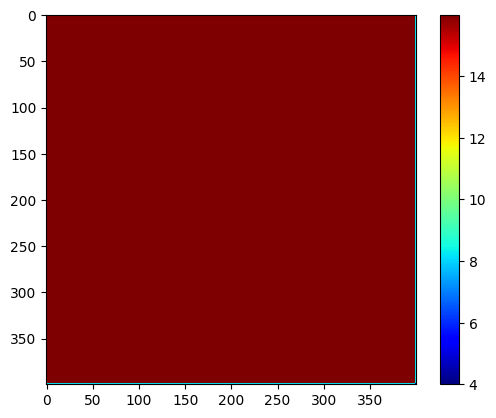

In [18]:
def getCubicBSpline2DGrid(iImageSize, iStep):
    dx, dy = iImageSize

    if not isinstance(iStep, (list, tuple)):
        iStep = (iStep, iStep)

    X, Y = np.meshgrid(
        np.arange(-iStep[0], np.ceil(dx / iStep[0] + 3) * iStep[0], iStep[0]),
        np.arange(-iStep[1], np.ceil(dy / iStep[1] + 3) * iStep[1], iStep[1])
    )

    return X, Y

def translateAndRotate(tx, ty, alpha):
    T = np.array([ [1, 0, tx],
                    [0, 1, ty],
                    [0, 0, 1] 
                ], dtype=np.float32)
    
    R = np.array([
        [np.cos(alpha), -np.sin(alpha), 0],
        [np.sin(alpha), np.cos(alpha), 0],
        [0, 0, 1]
    ], dtype=np.float32)

    return np.dot(R, T)

def ptTransform(T, iX, iY):
    iX = iX.flatten()
    iY = iY.flatten()
    iXY = np.vstack((iX, iY, np.ones(iX.shape)))

    oXY = np.dot(T, iXY)
    return oXY[0], oXY[1]

def getJacobianDet(iImageSize, iCPx, iCPy, iStep):
    if not isinstance(iStep, (list, tuple)):
        iStep = (iStep, iStep)
    # Grid for the image
    dy, dx = iImageSize
    gx, gy = np.meshgrid(np.arange(dx), np.arange(dy))
    gx = np.array(gx, dtype='float64')
    gy = np.array(gy, dtype='float64')

    # Deformation fields are the direct mapping of the deformed control points
    oGx = np.zeros_like(gx)
    oGy = np.zeros_like(gy)

    for l in (0, 1, 2, 3):
        for m in (0, 1, 2, 3):
            i = np.floor(gx / iStep[0]).astype('int64')
            j = np.floor(gy / iStep[1]).astype('int64')
            u = gx / iStep[0] - i
            v = gy / iStep[1] - j
            oGx += B[l](u) * B[m](v) * iCPx[j + m, i + l]
            oGy += B[l](u) * B[m](v) * iCPy[j + m, i + l]

    # Calculate partial derivatives using Sobel filters (preserve shape)
    doGx_dx = sobel(oGx, axis=1, mode='nearest') / 2.0  # ∂oGx/∂x
    doGx_dy = sobel(oGx, axis=0, mode='nearest') / 2.0  # ∂oGx/∂y
    doGy_dx = sobel(oGy, axis=1, mode='nearest') / 2.0  # ∂oGy/∂x
    doGy_dy = sobel(oGy, axis=0, mode='nearest') / 2.0  # ∂oGy/∂y

    # Compute Jacobian determinant
    jacobian_determinant = doGx_dx * doGy_dy - doGx_dy * doGy_dx
    
    return jacobian_determinant

iX, iY = getCubicBSpline2DGrid((400, 400), 80)
T = translateAndRotate(30, -10, np.pi / 6)
oX, oY = ptTransform(T, iX, iY)

oX = np.reshape(oX, iX.shape)
oY = np.reshape(oY, iY.shape)

jacDet = getJacobianDet((400, 400), oX, oY, 80)

jacDetBefore = getJacobianDet((400, 400), iX, iY, 80)

plt.figure()
plt.imshow(jacDet, cmap='jet')
plt.colorbar()
plt.show()

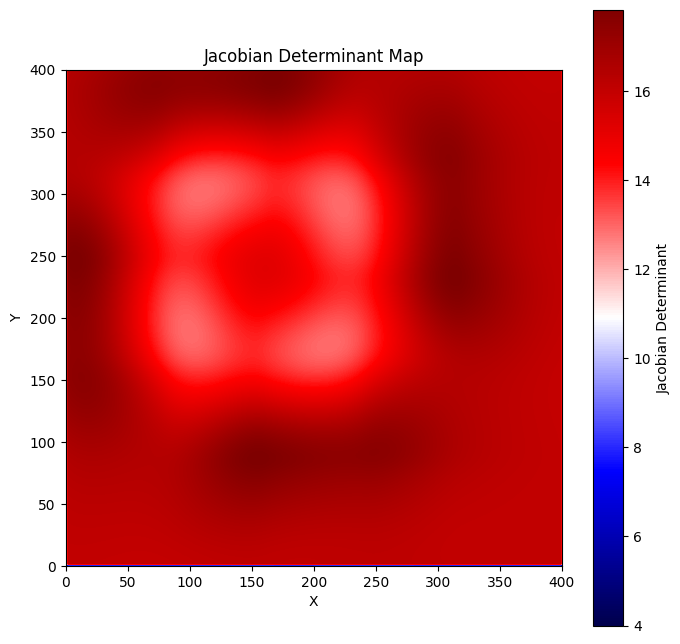

In [ ]:
from scipy.interpolate import interpn

def getChessBoardImage(iImageSize, iArraySize=10, dtype='uint8'):
    dy = int(np.ceil(iImageSize[0] / iArraySize)) + 1
    dx = int(np.ceil(iImageSize[1] / iArraySize)) + 1

    A = [255 * np.ones(shape=(iArraySize, iArraySize)), 
         np.zeros(shape=(iArraySize, iArraySize))]
    board = np.array(np.vstack([np.hstack([A[(i + j) % 2] \
                                           for i in range(dx)]) \
                                for j in range(dy)]), dtype=dtype)
    
    return board[:iImageSize[0], :iImageSize[1]]

def swirlControlPoints(iCPx, iCPy, a=2.0, b=100.0):
    oCPx = np.array(iCPx)
    oCPy = np.array(iCPy)
    xc = np.mean(oCPx[1:-3,1:-3])
    yc = np.mean(oCPy[1:-3,1:-3])
    rx1 = oCPx[1:-3,1:-3] - xc
    ry1 = oCPy[1:-3,1:-3] - yc
    angle = a*np.exp(-(rx1*rx1+ry1*ry1)/(b*b))
    oCPx[1:-3,1:-3] = np.cos(angle)*rx1 + np.sin(angle)*ry1 + xc
    oCPy[1:-3,1:-3] = -np.sin(angle)*rx1 + np.cos(angle)*ry1 + xc
    return oCPx, oCPy

def getCubicBSpline2DDeformation(iImageSize, iCPx, iCPy, iStep):
    dy, dx = iImageSize
    gx, gy = np.meshgrid(np.arange(dx), np.arange(dy))
    gx = np.array(gx, dtype='float64')
    gy = np.array(gy, dtype='float64')
    oGx = np.zeros_like(gx)
    oGy = np.zeros_like(gy)
    for l in (0, 1, 2, 3):
        for m in (0, 1, 2, 3):
            i = np.floor(gx / iStep[0])
            j = np.floor(gy / iStep[1])
            u = gx / iStep[0] - i
            v = gy / iStep[1] - j
            oGx += B[l](u) * B[m](v) * iCPx[
                    np.array(j, dtype='int64') + m, 
                    np.array(i, dtype='int64') + l]
            oGy += B[l](u) * B[m](v) * iCPy[
                    np.array(j, dtype='int64') + m, 
                    np.array(i, dtype='int64') + l]
    return oGx, oGy

def deformImageBSpline2D(iImage, iCPx, iCPy, iStep):
    dy, dx = iImage.shape
    oGx, oGy = getCubicBSpline2DDeformation(iImage.shape, iCPx, iCPy, iStep)
    gx, gy = np.meshgrid(np.arange(dx), np.arange(dy))
    oGx = 2*gx - oGx
    oGy = 2*gy - oGy

    oImage = interpn((np.arange(dy), np.arange(dx)), iImage.astype('float64'),
                     np.dstack((oGy, oGx)), method='linear', bounds_error=False,
                     fill_value=0) # bounds error dopušča, da se točke izven slike interpolirajo
    return oImage

# določi velikost slike in velikost polja šahovnice
cbImage = getChessBoardImage((400,400), 50)

# določi korak vzorčenja kontrolnih točk
iStep = (80, 80)

# ustvari kontrolne točke
oCPx, oCPy = getCubicBSpline2DGrid(cbImage.shape, iStep)

# premakni kontrolne točke glede na funkcijo vrtinca
oCPx_swirl, oCPy_swirl = swirlControlPoints(oCPx, oCPy, a=2.0, b=100.0)

# izračunaj polje deformacij
oGx, oGy = getCubicBSpline2DDeformation(
    cbImage.shape, oCPx_swirl, oCPy_swirl, iStep)

jacobian_determinant = getJacobianDet(cbImage.shape, oCPx_swirl, oCPy_swirl, iStep)

plt.figure(figsize=(8, 8))
plt.imshow(jacobian_determinant, cmap='seismic', extent=(0, cbImage.shape[1], 0, cbImage.shape[0]))
plt.colorbar(label='Jacobian Determinant')
plt.title('Jacobian Determinant Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


4. Z netogo poravnavo iz Naloge 5 v navodilih, pri čemer so kontrolne točke B--zlepkov dane v spremenljivki `outTx`, lahko z naslednjimi ukazi pridobite polje deformacij:
  ```python
  # ustvari polje deformacij na osnovi kontrolnih točk
  displacement = sitk.TransformToDisplacementField(
      outTx,
      size=fixed.GetSize(),
      outputOrigin=fixed.GetOrigin(),
      outputSpacing=fixed.GetSpacing(),
      outputDirection=fixed.GetDirection()
  )
  # ustvari numpy.array polje
  arr = sitk.GetArrayFromImage(...)
  ```
  - Podobno kot pri Dodatni nalogi 1 izrišite polje deformacij v obliki vektorskega polja z ukazom `quiver` v knjižici `matplotlib.pyplot`.
  - Z ukazom `itk.DisplacementFieldJacobianDeterminant(displacement, True)` izračunajte polje Jacobijeve determinante in ga prikažite kot barvno sliko z lestvico `jet`.
  - Izračunajte spremembo prostornine v \% preko celotne slike za prejšnjo točko.

In [ ]:
# YOUR CODE HERE
import numpy as np

arr = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0]
])

print(arr[[0, 1, 2, 3, 4], [0, 1, 2, 3, 4]]) # indexira elemente vrne tko (0,0) (1,1) (2,2) (3,3) (4,4) seprau dobis diagonalo

[0 1 1 1 0]
[[1 1 1]
 [1 1 1]
 [1 1 1]]
[[0 0 0]
 [1 1 0]
 [1 1 0]
 [1 1 0]
 [0 0 0]]
